In [1]:
from SimPEG import EM, Mesh, Utils, Maps, Survey
from SimPEG import DataMisfit, Regularization, Optimization, InvProblem, Directives, Inversion
# from SimPEG.EM.Static import DC
from SimPEG.EM import FDEM, mu_0
import numpy as np
from pymatsolver import PardisoSolver

# from ipywidgets import interact, IntSlider
%pylab inline
%matplotlib notebook
# %matplotlib inline
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 14

from itertools import combinations
from itertools import permutations
from matplotlib import gridspec

# import plotly
# import plotly.graph_objs as go

import time
# import sys
# sys.path.append("./utilcodes/")
# from vizutils import viz, gettopoCC, vizEJ
import pickle


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load Mesh
mesh = Mesh.TreeMesh.readUBC('./StraightTunnel_MultiBlk_Octree_Core14_10_6_1kmPad_Reg.msh')
print(mesh.nC)

# Load True Block model
sigmaTrue = mesh.readModelUBC('./StraightTunnel_MultiBlk_Octree_Core14_10_6_1kmPad_Reg.mod')
print(sigmaTrue.shape)

# Identify tunnel aircells
airInd = sigmaTrue == 1e-8
# print(np.where(airInd))

216105
(216105,)


In [3]:
def line(a, t, l):
    """
        Linear interpolation between a and b
        0 <= t <= 1
    """
    return a + t * l

In [4]:
def weight(t, a1, l1, h1, a2, l2, h2):
    """
        Edge basis functions
    """
    x1 = line(a1, t, l1)
    x2 = line(a2, t, l2)
    w0 = (1. - x1 / h1) * (1. - x2 / h2)
    w1 = (x1 / h1) * (1. - x2 / h2)
    w2 = (1. - x1 / h1) * (x2 / h2)
    w3 = (x1 / h1) * (x2 / h2)
    return np.r_[w0, w1, w2, w3]


In [5]:
# TODO: Extend this when current is defined on cell-face
def getStraightLineCurrentIntegral(hx, hy, hz, ax, ay, az, bx, by, bz):
    """
      Compute integral int(W . J dx^3) in brick of size hx x hy x hz
      where W denotes the 12 local bilinear edge basis functions
      and where J prescribes a unit line current
      between points (ax,ay,az) and (bx,by,bz).
    """

    # length of line segment
    lx = bx - ax
    ly = by - ay
    lz = bz - az
    l = np.sqrt(lx**2+ly**2+lz**2)

    if l == 0:
        sx = np.zeros(4, 1)
        sy = np.zeros(4, 1)
        sz = np.zeros(4, 1)

    # integration using Simpson's rule
    wx0 = weight(0., ay, ly, hy, az, lz, hz)
    wx0_5 = weight(0.5, ay, ly, hy, az, lz, hz)
    wx1 = weight(1., ay, ly, hy, az, lz, hz)

    wy0 = weight(0., ax, lx, hx, az, lz, hz)
    wy0_5 = weight(0.5, ax, lx, hx, az, lz, hz)
    wy1 = weight(1., ax, lx, hx, az, lz, hz)

    wz0 = weight(0., ax, lx, hx, ay, ly, hy)
    wz0_5 = weight(0.5, ax, lx, hx, ay, ly, hy)
    wz1 = weight(1., ax, lx, hx, ay, ly, hy)

    sx = (wx0 + 4. * wx0_5 + wx1) * (lx / 6.)

    sy = (wy0 + 4. * wy0_5 + wy1) * (ly / 6.)
    sz = (wz0 + 4. * wz0_5 + wz1) * (lz / 6.)

    return sx, sy, sz



In [6]:
def findlast(x):
    if x.sum() == 0:
        return -1
    else:
        return np.arange(x.size)[x][-1]

In [7]:
# Permutations that we will use to text the ordering of the edges
possibleOrders = list(permutations([0,1,2,3]))
print(possibleOrders)

print(list(possibleOrders[0]))

[(0, 1, 2, 3), (0, 1, 3, 2), (0, 2, 1, 3), (0, 2, 3, 1), (0, 3, 1, 2), (0, 3, 2, 1), (1, 0, 2, 3), (1, 0, 3, 2), (1, 2, 0, 3), (1, 2, 3, 0), (1, 3, 0, 2), (1, 3, 2, 0), (2, 0, 1, 3), (2, 0, 3, 1), (2, 1, 0, 3), (2, 1, 3, 0), (2, 3, 0, 1), (2, 3, 1, 0), (3, 0, 1, 2), (3, 0, 2, 1), (3, 1, 0, 2), (3, 1, 2, 0), (3, 2, 0, 1), (3, 2, 1, 0)]
[0, 1, 2, 3]


In [8]:
# Test code which substitutes for the getSourceTermLineCurrentPolygon function (SimPEG/EM/Utils/CurrentUtils.py)
# for a single segment of wire between 2 points, A and B.

hx = mesh.hx
hy = mesh.hy
hz = mesh.hz

nx = len(hx)
ny = len(hy)
nz = len(hz)

xorig = mesh.x0
x0, y0, z0 = xorig[0], xorig[1], xorig[2]

# nodal grid
x = np.r_[x0, x0+np.cumsum(hx)]
y = np.r_[y0, y0+np.cumsum(hy)]
z = np.r_[z0, z0+np.cumsum(hz)]

# discrete edge vectors 
sx = np.zeros(mesh.nEx)
sy = np.zeros(mesh.nEy)
sz = np.zeros(mesh.nEz)

# Test points A and B which will be connected with the current wire path
# A = np.array([5.25, 0.45, 2.15])
# ax = A[0]
# ay = A[1]
# az = A[2]

# B = np.array([5.25, 0.45, 2.35])
# bx = B[0]
# by = B[1]
# bz = B[2]

A = np.array([5., 0., 2.])
ax = A[0]
ay = A[1]
az = A[2]

B = np.array([15., 7., 3.])
bx = B[0]
by = B[1]
bz = B[2]

# find intersection with mesh planes
dx = bx - ax
dy = by - ay
dz = bz - az
d = np.sqrt(dx**2+dy**2+dz**2)

tol = d * np.finfo(float).eps

if abs(dx) > tol:
    tx = (x - ax) / dx
    tx = tx[np.logical_and(tx >= 0, tx <= 1)]
else:
    tx = []

if abs(dy) > tol:
    ty = (y - ay) / dy
    ty = ty[np.logical_and(ty >= 0, ty <= 1)]
else:
    ty = []

if abs(dz) > tol:
    tz = (z - az) / dz
    tz = tz[np.logical_and(tz >= 0, tz <= 1)]
else:
    tz = []

t = np.unique(np.r_[0., tx, ty, tz, 1.])
print('t=', t)
print(t.shape)
nq = len(t) - 1
print('nq=', nq)
# print(len(t[:nq]))
# print(len(t[1:nq+1]))
tc = 0.5 * (t[:nq] + t[1:nq+1])
print('tc =', tc)

for iq in range(nq):

    cx = ax + tc[iq] * dx
#     print('cx =', cx)
    cy = ay + tc[iq] * dy
#     print('cy =', cy)
    cz = az + tc[iq] * dz
    print('(cx, cy, cz) =', cx, cy, cz)

    # locate cell id

    ix = findlast(np.logical_and(cx >= x[:nx-1], cx <= x[1:nx]))
    iy = findlast(np.logical_and(cy >= y[:ny-1], cy <= y[1:ny]))
    iz = findlast(np.logical_and(cz >= z[:nz-1], cz <= z[1:nz]))
    print('(ix, iy, iz) =', ix, iy, iz)

    # local coordinates
    hxloc = hx[ix]
    hyloc = hy[iy]
    hzloc = hz[iz]
    print('(hxloc, hyloc, hzloc) =', hxloc, hyloc, hzloc)
    axloc = ax + t[iq]   * dx - x[ix]
    ayloc = ay + t[iq]   * dy - y[iy]
    azloc = az + t[iq]   * dz - z[iz]
    print('(axloc, ayloc, azloc) =', axloc, ayloc, azloc)
    bxloc = ax + t[iq+1] * dx - x[ix]
    byloc = ay + t[iq+1] * dy - y[iy]
    bzloc = az + t[iq+1] * dz - z[iz]
    print('(bxloc, byloc, bzloc) =', bxloc, byloc, bzloc)
    
        # integrate
    sxloc, syloc, szloc = getStraightLineCurrentIntegral(hxloc, hyloc,
                                                         hzloc, axloc,
                                                         ayloc, azloc,
                                                         bxloc, byloc,
                                                         bzloc)
    print('(sxloc, syloc, szloc) =', sxloc, syloc, szloc)
    
    
    cID =  mesh._get_containing_cell_index([cx,cy,cz])
    CC = mesh.gridCC[cID,:]
    CCx = CC[0]
    CCy = CC[1]
    CCz = CC[2]
    print('CC =', CC)
#     print(cID)
    xEdgeLocs = mesh.gridEx
    d_xEdge = np.sqrt((xEdgeLocs[:,0] - CCx)**2 + (xEdgeLocs[:,1] - CCy)**2 + (xEdgeLocs[:,2] - CCz)**2)
    print(min(mesh.hx))
    xEdgeInd = np.where(d_xEdge < min(mesh.hx))
    
    yEdgeLocs = mesh.gridEy
    d_yEdge = np.sqrt((yEdgeLocs[:,0] - CCx)**2 + (yEdgeLocs[:,1] - CCy)**2 + (yEdgeLocs[:,2] - CCz)**2)
    print(min(mesh.hy))
    yEdgeInd = np.where(d_yEdge < min(mesh.hy))
    
    zEdgeLocs = mesh.gridEz
    d_zEdge = np.sqrt((zEdgeLocs[:,0] - CCx)**2 + (zEdgeLocs[:,1] - CCy)**2 + (zEdgeLocs[:,2] - CCz)**2)
    print(min(mesh.hz))
    zEdgeInd = np.where(d_zEdge < min(mesh.hz))
    
    print('(xEdgeInd, yEdgeInd, zEdgeInd) =', xEdgeInd, yEdgeInd, zEdgeInd)
    
    
#    # Assign src values based on distance of edges from (cx, cy, cz)
#    # Not sure if this is the right approach ???

#     cxDist = np.sqrt((xEdgeLocs[xEdgeInd,0] - cx)**2 + (xEdgeLocs[xEdgeInd,1] - cy)**2 + (xEdgeLocs[xEdgeInd,2] - cz)**2)[0]
#     print('cxDist =', cxDist)
#     cxDistSortInd = np.argsort(cxDist)
#     print('cxDistSortInd =', cxDistSortInd)
#     sxlocSortInd = np.argsort(sxloc)[::-1]
#     print('sxlocSortInd =', sxlocSortInd)
    
#     cyDist = np.sqrt((yEdgeLocs[yEdgeInd,0] - cx)**2 + (yEdgeLocs[yEdgeInd,1] - cy)**2 + (yEdgeLocs[yEdgeInd,2] - cz)**2)[0]
#     print('cyDist =', cyDist)
#     cyDistSortInd = np.argsort(cyDist)
# #     print('cyDistSortInd =', cyDistSortInd)
#     sylocSortInd = np.argsort(syloc)[::-1]
# #     print('sylocSortInd =', sylocSortInd)
    
#     czDist = np.sqrt((zEdgeLocs[zEdgeInd,0] - cx)**2 + (zEdgeLocs[zEdgeInd,1] - cy)**2 + (zEdgeLocs[zEdgeInd,2] - cz)**2)[0]
#     print('czDist =', czDist)
#     czDistSortInd = np.argsort(czDist)
# #     print('czDistSortInd =', czDistSortInd)
#     szlocSortInd = np.argsort(szloc)[::-1]
# #     print('szlocSortInd =', szlocSortInd)
   
#     xEdgeInd = xEdgeInd[0]
#     xEdgeOrderInd = xEdgeInd[cxDistSortInd]
#     print('xEdgeOrderInd =', xEdgeOrderInd)
#     print('sxloc[sxlocSortInd] =', sxloc[sxlocSortInd])
    
#     yEdgeInd = yEdgeInd[0]
#     yEdgeOrderInd = yEdgeInd[cyDistSortInd]
#     print('yEdgeOrderInd =', yEdgeOrderInd)
#     print('syloc[sylocSortInd] =', syloc[sylocSortInd])
    
#     zEdgeInd = zEdgeInd[0]
#     zEdgeOrderInd = zEdgeInd[czDistSortInd]
#     print('zEdgeOrderInd =', zEdgeOrderInd)
#     print('szloc[szlocSortInd] =', szloc[szlocSortInd])
    
#     sx[xEdgeOrderInd] += sxloc[sxlocSortInd]
#     sy[yEdgeOrderInd] += syloc[sylocSortInd]
#     sz[zEdgeOrderInd] += szloc[szlocSortInd]


#     # Test ording permutations
#     sx[xEdgeInd] += sxloc[list(possibleOrders[0])]
#     sy[yEdgeInd] += syloc[list(possibleOrders[0])]
#     sz[zEdgeInd] += szloc[list(possibleOrders[0])]

    sx[xEdgeInd] += sxloc
    sy[yEdgeInd] += syloc
    sz[zEdgeInd] += szloc

Src = np.r_[sx, sy, sz]


t= [0.         0.05       0.07142857 0.15       0.21428571 0.25
 0.35       0.35714286 0.45       0.5        0.55       0.64285714
 0.65       0.75       0.78571429 0.85       0.92857143 0.95
 1.        ]
(19,)
nq= 18
tc = [0.025      0.06071429 0.11071429 0.18214286 0.23214286 0.3
 0.35357143 0.40357143 0.475      0.525      0.59642857 0.64642857
 0.7        0.76785714 0.81785714 0.88928571 0.93928571 0.975     ]
(cx, cy, cz) = 5.25 0.17500000000000002 2.025
(ix, iy, iz) = 1004 1024 1047
(hxloc, hyloc, hzloc) = 1.0 1.0 1.0
(axloc, ayloc, azloc) = 0.5 0.5 0.5
(bxloc, byloc, bzloc) = 1.0 0.8500000000000001 0.5499999999999998
(sxloc, syloc, szloc) = [0.07791667 0.15958333 0.08458333 0.17791667] [0.04229167 0.12395833 0.04520833 0.13854167] [0.00479167 0.01145833 0.00770833 0.02604167]
CC = [5. 0. 2.]
1.0
1.0
1.0
(xEdgeInd, yEdgeInd, zEdgeInd) = (array([64421, 64452, 66637, 66668]),) (array([64594, 64626, 66834, 66866]),) (array([63769, 65781, 65811, 67471]),)
(cx, cy, cz) = 5.60714285714

1.0
1.0
1.0
(xEdgeInd, yEdgeInd, zEdgeInd) = (array([90385, 90410, 92595, 92619]),) (array([91237, 91262, 93477, 93502]),) (array([90229, 91849, 91873, 93972]),)
(cx, cy, cz) = 13.892857142857142 6.225 2.8892857142857142
(ix, iy, iz) = 1013 1030 1048
(hxloc, hyloc, hzloc) = 1.0 1.0 1.0
(axloc, ayloc, azloc) = 0.0 0.4500000000000002 0.3500000000000001
(bxloc, byloc, bzloc) = 0.7857142857142865 1.0 0.4285714285714288
(sxloc, syloc, szloc) = [0.13478741 0.34505952 0.08128401 0.22458333] [0.20676446 0.1291284  0.12716412 0.08694303] [0.01594813 0.00565901 0.03175595 0.02520833]
CC = [14.  6.  3.]
1.0
1.0
1.0
(xEdgeInd, yEdgeInd, zEdgeInd) = (array([92571, 92596, 93842, 93866]),) (array([93477, 93502, 94763, 94788]),) (array([91849, 93926, 93972, 95870]),)
(cx, cy, cz) = 14.392857142857142 6.575 2.939285714285714
(ix, iy, iz) = 1013 1031 1048
(hxloc, hyloc, hzloc) = 1.0 1.0 1.0
(axloc, ayloc, azloc) = 0.7857142857142865 0.0 0.4285714285714288
(bxloc, byloc, bzloc) = 1.0 0.14999999999999947 

In [9]:
print(Src.shape)
SrcInd = np.where(Src)[0]
print(SrcInd)
print(len(SrcInd))
print(len(SrcInd)/4)

(618323,)
[ 64421  64452  66607  66637  66638  66668  68348  68379  70534  70564
  70565  70594  71731  71761  73917  73946  73947  73975  75628  75657
  75658  75686  77843  77872  79090  79118  79119  79146  81304  81332
  81359  83043  83069  83070  83095  85255  85281  86463  86488  86489
  86513  88649  88674  88675  88699  90385  90410  92571  92595  92596
  92619  93842  93866  96028  96051  96052  96074  97762  97785 269187
 269219 271427 271459 273184 273215 273216 273246 275455 275486 276661
 276691 276692 276721 278931 278961 280688 280718 282928 282957 282958
 282986 284243 284272 286483 286512 286539 286566 288296 288323 290536
 290562 290563 290588 291808 291834 294048 294074 295805 295830 295831
 295855 298070 298095 299356 299380 299381 299404 301620 301644 303377
 303401 475259 477271 477301 478931 478961 480647 480677 482787 482839
 484993 485022 486675 486704 488339 488368 490388 490438 492365 492393
 492421 494097 494125 494173 495767 495793 497950 497988 499968 499

In [10]:
print(mesh.nE)
print(mesh.nEx)
print(mesh.nEy)
print(mesh.nEz)

ExInd = SrcInd[SrcInd <= mesh.nEx]
print('ExInd=', ExInd)
EyInd = SrcInd[np.all(np.vstack([mesh.nEx <= SrcInd, SrcInd <= (mesh.nEx + mesh.nEy)]).T, axis=1)] - mesh.nEx
print('EyInd=', EyInd)
EzInd = SrcInd[np.all(np.vstack([(mesh.nEx + mesh.nEy) <= SrcInd, SrcInd <= mesh.nE]).T, axis=1)] - (mesh.nEx + mesh.nEy)
print('EzInd=', EzInd)

srcX_Value = sx[np.where(sx != 0)]
print(srcX_Value)
srcY_Value = sy[np.where(sy != 0)]
print(srcY_Value)
srcZ_Value = sz[np.where(sz != 0)]
print(srcZ_Value)

618323
204593
206897
206833
ExInd= [64421 64452 66607 66637 66638 66668 68348 68379 70534 70564 70565 70594
 71731 71761 73917 73946 73947 73975 75628 75657 75658 75686 77843 77872
 79090 79118 79119 79146 81304 81332 81359 83043 83069 83070 83095 85255
 85281 86463 86488 86489 86513 88649 88674 88675 88699 90385 90410 92571
 92595 92596 92619 93842 93866 96028 96051 96052 96074 97762 97785]
EyInd= [64594 64626 66834 66866 68591 68622 68623 68653 70862 70893 72068 72098
 72099 72128 74338 74368 76095 76125 78335 78364 78365 78393 79650 79679
 81890 81919 81946 81973 83703 83730 85943 85969 85970 85995 87215 87241
 89455 89481 91212 91237 91238 91262 93477 93502 94763 94787 94788 94811
 97027 97051 98784 98808]
EzInd= [63769 65781 65811 67441 67471 69157 69187 71297 71349 73503 73532 75185
 75214 76849 76878 78898 78948 80875 80903 80931 82607 82635 82683 84277
 84303 86460 86498 88478 88503 90204 90229 91849 91873 93926 93972 95870
 95893 97618 97641 99239]
[7.79166667e-02 1.59583333e-

In [11]:
def plotGrid_Src(
    mesh, ax=None, nodes=False, nodeInd=[], faces=False, FxInd=[], FyInd=[], FzInd=[], centers=False, CCInd=[], 
    edges=False, ExInd=[], EyInd=[], EzInd=[], lines=True, showIt=False,):
    """Plot the nodal, cell-centered and staggered grids for 1,2 and 3 dimensions.

    :param bool nodes: plot nodes
    :param bool faces: plot faces
    :param bool centers: plot centers
    :param bool edges: plot edges
    :param bool lines: plot lines connecting nodes
    :param bool showIt: call plt.show()

    .. plot::
       :include-source:

       import discretize
       import numpy as np
       h1 = np.linspace(.1, .5, 3)
       h2 = np.linspace(.1, .5, 5)
       mesh = discretize.TensorMesh([h1, h2])
       mesh.plotGrid(nodes=True, faces=True, centers=True, lines=True, showIt=True)

    .. plot::
       :include-source:

       import discretize
       import numpy as np
       h1 = np.linspace(.1, .5, 3)
       h2 = np.linspace(.1, .5, 5)
       h3 = np.linspace(.1, .5, 3)
       mesh = discretize.TensorMesh([h1, h2, h3])
       mesh.plotGrid(nodes=True, faces=True, centers=True, lines=True, showIt=True)

    """

    axOpts = {'projection': '3d'} if mesh.dim == 3 else {}
    if ax is None:
        plt.figure(figsize=[12.4, 10.8])
        ax = plt.subplot(111, **axOpts)
    else:
        if not isinstance(ax, matplotlib.axes.Axes):
            raise AssertionError("ax must be an matplotlib.axes.Axes")

#         if mesh.dim == 1:
#             if nodes:
#                 ax.plot(
#                     mesh.gridN, np.ones(mesh.nN), color="C0", marker="s",
#                     linestyle=""
#                 )
#             if centers:
#                 ax.plot(
#                     mesh.gridCC, np.ones(mesh.nC), color="C1", marker="o",
#                     linestyle=""
#                 )
#             if lines:
#                 ax.plot(
#                     mesh.gridN, np.ones(mesh.nN), color="C0", linestyle="-"
#                 )
#             ax.set_xlabel('x1')
#         elif mesh.dim == 2:
#             if nodes:
#                 ax.plot(
#                     mesh.gridN[:, 0], mesh.gridN[:, 1], color="C0", marker="s",
#                     linestyle=""
#                 )
#             if centers:
#                 ax.plot(
#                     mesh.gridCC[:, 0], mesh.gridCC[:, 1], color="C1",
#                     marker="o", linestyle=""
#                 )
#             if faces:
#                 ax.plot(
#                     mesh.gridFx[:, 0], mesh.gridFx[:, 1], color="C2",
#                     marker=">", linestyle=""
#                 )
#                 ax.plot(
#                     mesh.gridFy[:, 0], mesh.gridFy[:, 1], color="C2",
#                     marker="^", linestyle=""
#                 )
#             if edges:
#                 ax.plot(
#                     mesh.gridEx[:, 0], mesh.gridEx[:, 1], color="C3",
#                     marker=">", linestyle=""
#                 )
#                 ax.plot(
#                     mesh.gridEy[:, 0], mesh.gridEy[:, 1], color="C3",
#                     marker="^", linestyle=""
#                 )

#             color = kwargs.get('color', 'C0')
#             linewidth = kwargs.get('linewidth', 1.)
#             # Plot the grid lines
#             if lines:
#                 NN = mesh.r(mesh.gridN, 'N', 'N', 'M')
#                 X1 = np.c_[Utils.mkvc(NN[0][0, :]), Utils.mkvc(NN[0][mesh.nCx, :]), Utils.mkvc(NN[0][0, :])*np.nan].flatten()
#                 Y1 = np.c_[Utils.mkvc(NN[1][0, :]), Utils.mkvc(NN[1][mesh.nCx, :]), Utils.mkvc(NN[1][0, :])*np.nan].flatten()
#                 X2 = np.c_[Utils.mkvc(NN[0][:, 0]), Utils.mkvc(NN[0][:, mesh.nCy]), Utils.mkvc(NN[0][:, 0])*np.nan].flatten()
#                 Y2 = np.c_[Utils.mkvc(NN[1][:, 0]), Utils.mkvc(NN[1][:, mesh.nCy]), Utils.mkvc(NN[1][:, 0])*np.nan].flatten()
#                 X = np.r_[X1, X2]
#                 Y = np.r_[Y1, Y2]
#                 ax.plot(X, Y, color=color, linestyle="-", lw=linewidth)

#             ax.set_xlabel('x1')
#             ax.set_ylabel('x2')
    if mesh.dim == 3:
        if nodes:
            ax.plot(
                mesh.gridN[nodeInd, 0], mesh.gridN[nodeInd, 1], color="C0", marker="s",
                linestyle="", zs=mesh.gridN[nodeInd, 2]
            )
        if centers:
            ax.plot(
                mesh.gridCC[CCInd, 0], mesh.gridCC[CCInd, 1], color="C1",
                marker="o", linestyle="", zs=mesh.gridCC[CCInd, 2]
            )
        if faces:
            ax.plot(
                mesh.gridFx[FxInd, 0], mesh.gridFx[FxInd, 1], color="C2",
                marker=">", linestyle="", zs=mesh.gridFx[FxInd, 2]
            )
            ax.plot(
                mesh.gridFy[FyInd, 0], mesh.gridFy[FyInd, 1], color="C3",
                marker="<", linestyle="", zs=mesh.gridFy[FyInd, 2]
            )
            ax.plot(
                mesh.gridFz[FzInd, 0], mesh.gridFz[FzInd, 1], color="C4",
                marker="^", linestyle="", zs=mesh.gridFz[FzInd, 2]
            )
        if edges:
            ax.scatter(mesh.gridEx[ExInd, 0], mesh.gridEx[ExInd, 1], mesh.gridEx[ExInd, 2],
                c="C5" , s=1000*srcX_Value, marker=">"
            )
            ax.scatter(mesh.gridEy[EyInd, 0], mesh.gridEy[EyInd, 1], mesh.gridEy[EyInd, 2],
                c="C6" , s=1000*srcY_Value, marker="<"
            )
            ax.scatter(mesh.gridEz[EzInd, 0], mesh.gridEz[EzInd, 1], mesh.gridEz[EzInd, 2],
                c="C7" , s=1000*srcZ_Value, marker="^"
            )
#             ax.scatter(
#                 mesh.gridEx[ExInd, 0], mesh.gridEx[ExInd, 1], color="C5",
#                 marker=">", linestyle="", zs=mesh.gridEx[ExInd, 2]
#             )
#             ax.scatter(
#                 mesh.gridEy[EyInd, 0], mesh.gridEy[EyInd, 1], color="C6",
#                 marker="<", linestyle="", zs=mesh.gridEy[EyInd, 2]
#             )
#             ax.scatter(
#                 mesh.gridEz[EzInd, 0], mesh.gridEz[EzInd, 1], color="C7",
#                 marker="^", linestyle="", zs=mesh.gridEz[EzInd, 2]
#             )

        # Plot the grid lines
        if lines:
            NN = mesh.r(mesh.gridN, 'N', 'N', 'M')
            X1 = np.c_[Utils.mkvc(NN[0][0, :, :]), Utils.mkvc(NN[0][mesh.nCx, :, :]), Utils.mkvc(NN[0][0, :, :])*np.nan].flatten()
            Y1 = np.c_[Utils.mkvc(NN[1][0, :, :]), Utils.mkvc(NN[1][mesh.nCx, :, :]), Utils.mkvc(NN[1][0, :, :])*np.nan].flatten()
            Z1 = np.c_[Utils.mkvc(NN[2][0, :, :]), Utils.mkvc(NN[2][mesh.nCx, :, :]), Utils.mkvc(NN[2][0, :, :])*np.nan].flatten()
            X2 = np.c_[Utils.mkvc(NN[0][:, 0, :]), Utils.mkvc(NN[0][:, mesh.nCy, :]), Utils.mkvc(NN[0][:, 0, :])*np.nan].flatten()
            Y2 = np.c_[Utils.mkvc(NN[1][:, 0, :]), Utils.mkvc(NN[1][:, mesh.nCy, :]), Utils.mkvc(NN[1][:, 0, :])*np.nan].flatten()
            Z2 = np.c_[Utils.mkvc(NN[2][:, 0, :]), Utils.mkvc(NN[2][:, mesh.nCy, :]), Utils.mkvc(NN[2][:, 0, :])*np.nan].flatten()
            X3 = np.c_[Utils.mkvc(NN[0][:, :, 0]), Utils.mkvc(NN[0][:, :, mesh.nCz]), Utils.mkvc(NN[0][:, :, 0])*np.nan].flatten()
            Y3 = np.c_[Utils.mkvc(NN[1][:, :, 0]), Utils.mkvc(NN[1][:, :, mesh.nCz]), Utils.mkvc(NN[1][:, :, 0])*np.nan].flatten()
            Z3 = np.c_[Utils.mkvc(NN[2][:, :, 0]), Utils.mkvc(NN[2][:, :, mesh.nCz]), Utils.mkvc(NN[2][:, :, 0])*np.nan].flatten()
            X = np.r_[X1, X2, X3]
            Y = np.r_[Y1, Y2, Y3]
            Z = np.r_[Z1, Z2, Z3]
            ax.plot(X, Y, color="C0", linestyle="-", zs=Z)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('x3')
    else:
        print('Not implemented for 1 or 2D cases.')

    ax.grid(True)
    if showIt:
        plt.show()

    return ax

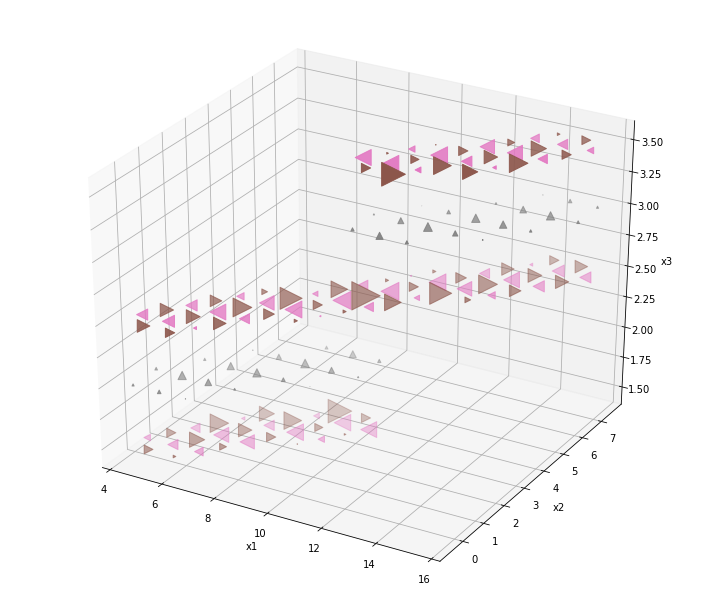

In [12]:
plotGrid_Src(mesh, edges=True, ExInd=ExInd, EyInd=EyInd, EzInd=EzInd, lines=False, showIt=True)